# Predicting Closing Price of BBRI
BBRI is the stock name of Bank Rakyat Indonesia. PT Bank Rakyat Indonesia (Persero) Tbk (People's Bank of Indonesia, commonly known as BRI or Bank BRI) is one of the largest banks in Indonesia. It specialises in small scale and microfinance style borrowing from and lending to its approximately 30 million retail clients through its over 4,000 branches, units and rural service posts. It also has a comparatively small, but growing, corporate business. As of 2010 it is the second largest bank in Indonesia by asset.

This dataset can be found using [Pandas DataReader](https://pandas-datareader.readthedocs.io/en/latest/) and will pick from January 2008 to the end of May 2020. It will be more than 12 years. In this session, we will predict the closing price of BBRI with Long Short-Term Memory. 

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition and anomaly detection in network traffic or IDS's (intrusion detection systems).

## 1) Data Preparation
Using Pandas DataReader, we can get dataset about the stock that we want to use. Of course we're using some libraries to make it happen.

In [0]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [0]:
# BBRI
bbri = web.DataReader('bbri.jk', 'yahoo', '2008-01-01', '2020-05-31')
bbri

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-01-02,740.0,730.0,735.0,735.0,44765000.0,96.595680
2008-01-03,735.0,710.0,735.0,720.0,102940000.0,94.624344
2008-01-04,755.0,715.0,720.0,750.0,143670000.0,98.567032
2008-01-07,750.0,730.0,735.0,745.0,63700000.0,97.909927
2008-01-08,755.0,745.0,750.0,750.0,84225000.0,98.567032
...,...,...,...,...,...,...
2020-05-20,2500.0,2320.0,2360.0,2480.0,394395900.0,2480.000000
2020-05-26,2550.0,2470.0,2550.0,2520.0,404097300.0,2520.000000
2020-05-27,2630.0,2520.0,2540.0,2630.0,432813000.0,2630.000000


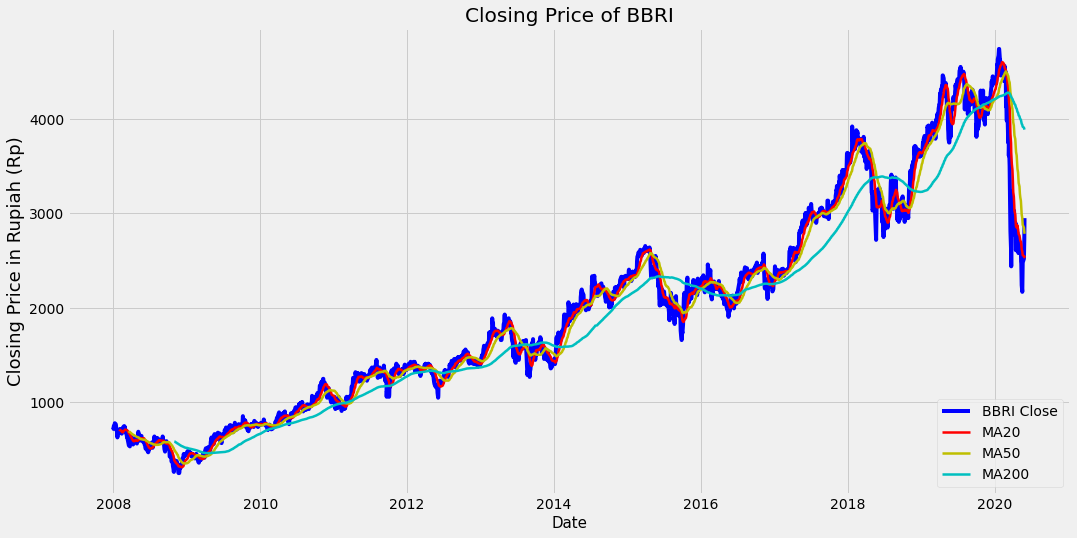

In [0]:
# Let's visualize the Closing Price

rolling_mean20 = bbri['Close'].rolling(window=20).mean()
rolling_mean50 = bbri['Close'].rolling(window=50).mean()
rolling_mean200 = bbri['Close'].rolling(window=200).mean()

plt.figure(figsize = (16,8))
plt.plot(bbri['Close'], color = 'b', label = 'BBRI Close')
plt.plot(rolling_mean20, color = 'r', linewidth = 2.5, label = 'MA20')
plt.plot(rolling_mean50, color = 'y', linewidth = 2.5, label = 'MA50')
plt.plot(rolling_mean200, color = 'c',linewidth = 2.5, label = 'MA200')

plt.xlabel('Date', fontsize = 15)
plt.ylabel('Closing Price in Rupiah (Rp)', fontsize = 18)
plt.title('Closing Price of BBRI')
plt.legend(loc = 'lower right')

Here the visualization of BBRI's closing price since 2008. Based on this graph, it's been a good money when you invest your money into this stock. Just saying. I'm showing you the Moving Average (MA) too withing 20, 50 and 200 days to make it more technical with these indicators.

## 2) Data Pre-processing
Now let's straight to the pre-processing. We have to prepare up like splitting our dataset into Train and Test dataset. We do this by call some libraries from sklearn.

In [0]:
# Don't forget to using 'values' attribute before apply it into Neural Network!

X = bbri.drop('Close', axis = 1).values
y = bbri['Close'].values

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Split the Data into Train and Test dataset with 20% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [0]:
X_train.shape

(2457, 5)

So, it's already splitted with 80:20. Notice our X_train size is 2457 (80% of the dataset).

In [0]:
# Scale it with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

In [0]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

After scaling our X dataset, we should reshape our dataset into proper one. Especially on X dataset, we should turn it into 3-dimensional data before apply it to LSTM NN model or you'll get some advices from the notebook.

In [0]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [0]:
# Reshape it into 3-dimensional before input it into LSTM Model.
# Reshape the data to be 3-dimensional in the form [number of samples, number of time steps, and number of features].

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## 3) Make a LSTM Model
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer. ([source](https://colah.github.io/posts/2015-08-Understanding-LSTMs/))
![LSTM](https://upload.wikimedia.org/wikipedia/commons/3/3b/The_LSTM_cell.png)


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

We use 5 neurons in input layer because we have 5 features along training our model. We add 1 hidden layer with 5 neurons and also [ReLU](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7) activation. Finally adding 1 layer for output. We choose [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) optimizer with mean squared error for calculating model's loss.

In [0]:
# just to remember our dataset shape

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2457, 5, 1)
(2457, 1)
(615, 5, 1)
(615, 1)


In [0]:
model = Sequential()

# input layer
model.add(LSTM(5, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(5, return_sequences= False))

# hidden layer
model.add(Dense(5, activation='relu'))
model.add(Dense(5, activation='relu'))

# output layer
model.add(Dense(1))

# compiler
model.compile(optimizer='adam', loss = 'mse')

I love efficiency, so I add Callbacks feature to the model with [EarlyStopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/) from TensorFlow to avoid overfitting and improve generalization.

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 25)

I set epochs to 500 iterations, but at the same time I do believe this model won't iterate more than 500 cause EarlyStopping will save us.

In [0]:
# Let's train our model!

model.fit(x = X_train,
          y = y_train,
          validation_data = (X_test, y_test),
          epochs = 500, 
          callbacks = [early_stop])

Epoch 1/500
77/77 [==============================] - 1s 14ms/step - loss: 5241865.0000 - val_loss: 5459447.5000
Epoch 2/500
77/77 [==============================] - 0s 6ms/step - loss: 5239880.5000 - val_loss: 5455414.5000
Epoch 3/500
77/77 [==============================] - 1s 7ms/step - loss: 5231770.0000 - val_loss: 5443294.0000
Epoch 4/500
77/77 [==============================] - 1s 8ms/step - loss: 5217286.5000 - val_loss: 5426387.5000
Epoch 5/500
77/77 [==============================] - 0s 6ms/step - loss: 5198236.0000 - val_loss: 5404889.0000
Epoch 6/500
77/77 [==============================] - 1s 7ms/step - loss: 5174009.5000 - val_loss: 5377636.0000
Epoch 7/500
77/77 [==============================] - 1s 7ms/step - loss: 5143811.0000 - val_loss: 5343848.5000
Epoch 8/500
77/77 [==============================] - 1s 8ms/step - loss: 5106931.0000 - val_loss: 5303201.5000
Epoch 9/500
77/77 [==============================] - 1s 8ms/step - loss: 5062730.0000 - val_loss: 5255062.5000


In [0]:
# So there are 214 iterations. Let's recap our training loss vs validation loss, and make it to DataFrame.

model_loss = pd.DataFrame(model.history.history)
model_loss

,loss,val_loss
0,5.241865e+06,5.459448e+06
1,5.239880e+06,5.455414e+06
2,5.231770e+06,5.443294e+06
3,5.217286e+06,5.426388e+06
4,5.198236e+06,5.404889e+06
...,...,...
209,6.545070e+02,7.786083e+02
210,6.468086e+02,8.517076e+02
211,6.568235e+02,1.233259e+03
212,6.418126e+02,7.152426e+02


Text(0.5, 0, 'n of Epochs')

<Figure size 864x432 with 0 Axes>

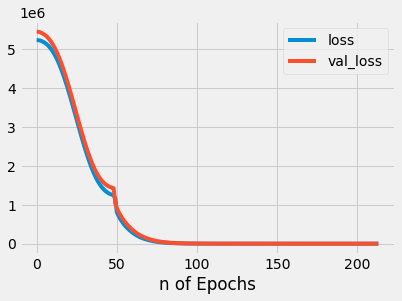

In [0]:
plt.figure(figsize = (12,6))
model_loss.plot()
plt.xlabel('n of Epochs')

I can't believe this our model get "just right" form along the training. We see that 'training loss' and 'validation loss' walk along the side. It's beautiful graph that you could see.

## 4) Predictions
Training is done, let's get our model to predict and compare it with y_test dataset. We will see the value of RMSE and linear regression graph.

In [0]:
from sklearn.metrics import mean_squared_error, explained_variance_score

In [0]:
predictions = model.predict(X_test)

In [0]:
# MSE
mean_squared_error(y_test, predictions)

771.7598666940899

In [0]:
# RMSE
np.sqrt(mean_squared_error(y_test, predictions))

27.780566349412133

In [0]:
# Explained variance regression score function

explained_variance_score(y_test, predictions)
# Best possible score is 1.0, lower values are worse (sklearn).

0.9995023478521047

We see that we get the value of RMSE is 27.781. It's very small according to the context of stocks. Look at the 'explained variance score', we get 0.995. Our model just did a great job. So what if we plot our valid dataset with model's prediction? Could we get some nice line of regression?

Text(0.5, 1.0, 'LSTM Model Prediction Evaluation')

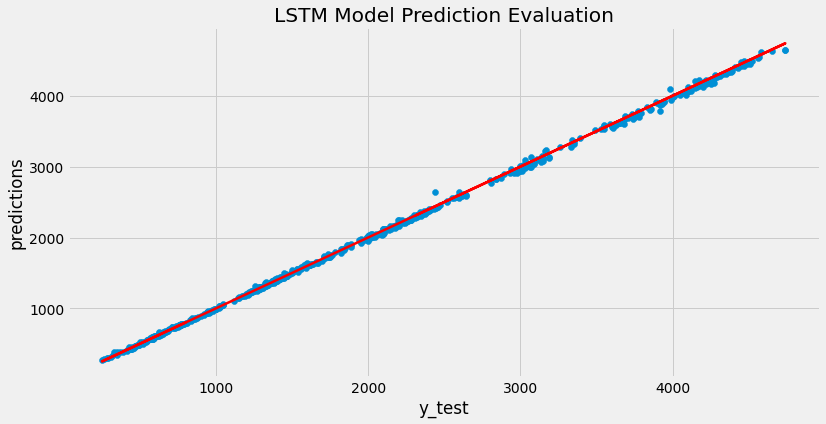

In [0]:
plt.figure(figsize=(12,6))
plt.scatter(y_test,predictions)
plt.plot(y_test, y_test, 'r', linewidth = 2.5)
plt.xlabel('y_test')
plt.ylabel('predictions')
plt.title('LSTM Model Prediction Evaluation')

Still can't believe this that our model's predictions just fit with y_test dataset. It shows fit very well with few outliers there. It's okay. Let's try to predict closing price of BBRI on June 2nd.

## 5) Predict with another data on June 2nd, 2020
First we get our dataset, then prepare it up into our model's prediction.

In [0]:
# BBRI
bbri2 = web.DataReader('bbri.jk', 'yahoo', '2020-06-02', '2020-06-02')
bbri2

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-06-02,3290,2950,2950,3180,467460800,3180


In [0]:
bbri2 = bbri2.drop('Close', axis = 1)

In [0]:
bbri2 = bbri2.values

In [0]:
bbri2 = scaler.transform(bbri2)

In [0]:
bbri2 = bbri2.reshape(-1, 5, 1)


In [0]:
model.predict(bbri2)

array([[3152.028]], dtype=float32)

Our model predicts 3152 of BBRI's closing price on June 2nd, 2020 while the actual close price is 3180. Well, that's not bad though since our model's RMSE is about 27 units and the evaluation just fit between its predictions and y_test dataset.